In [1]:
import numpy as np
import pandas as pd
from ase.io import read, write
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import seaborn as sns
from scipy.stats import kstest


plt.rc('font', family="sans-serif", weight="bold")          # controls default text sizes
plt.rc('axes', labelsize=15, titlesize=15)    # x and y axes
plt.rc('xtick', labelsize=15)    # Major Ticks
plt.rc('ytick', labelsize=15)    # Major Ticks
plt.rc('xtick.minor', visible=True)    # Minor Ticks
plt.rc('ytick.minor', visible=True)    # Minor Ticks
plt.rc('legend', fontsize=10)    # Legend
plt.rc('figure', titlesize=10)  # Figure title


plt.rcParams['figure.dpi'] = 300
print(plt.rcParams['font.family'])

['sans-serif']


# Load data

In [15]:
mol_model = read("Data\model_test_8_2.xyz", index=":")
mol_dyn = read("Data\EtOH_moldyn_data.xyz", index=":"+str(len(mol_model)))

df_model = pd.read_csv("Data\Moldyn_dataframe_test.csv")


In [10]:
def compare_KS(ref, test):
    return kstest(ref, test)

def compare_chi2(ref, test):
    return


# Forces

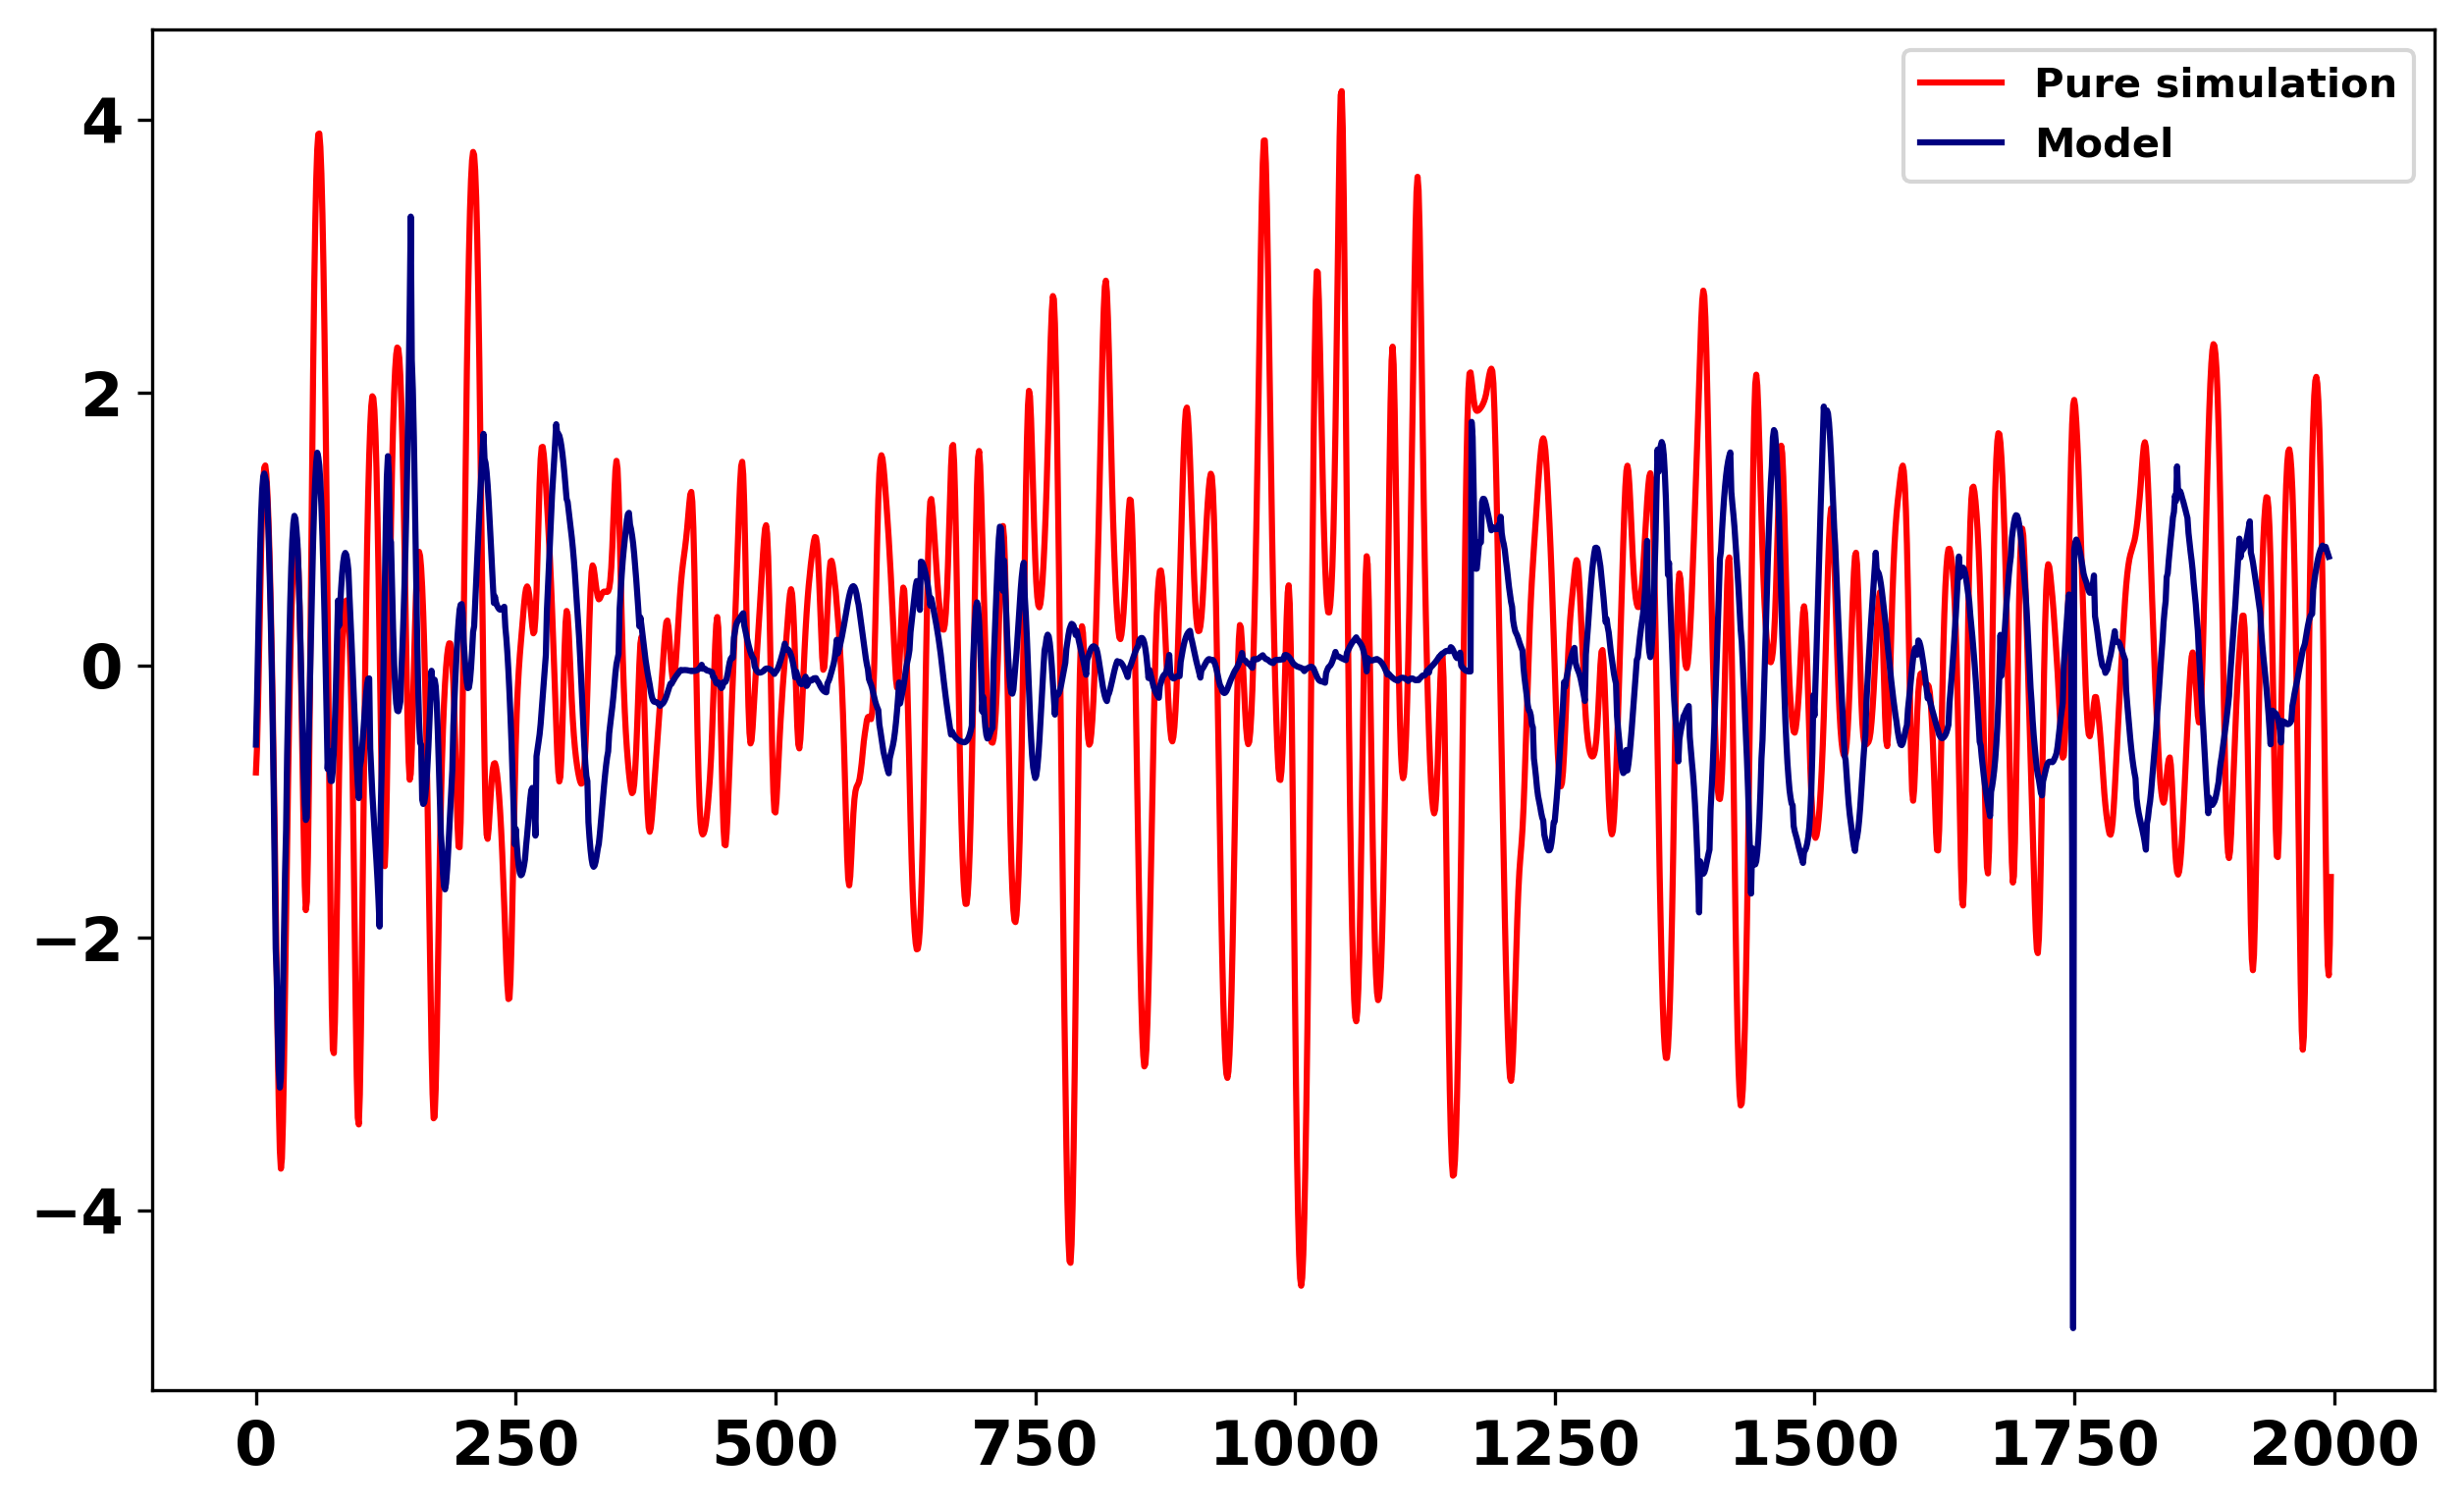

In [5]:
force = []
atom_nr = 0
for atom in mol_dyn:
    force.append(atom.get_forces()[atom_nr, 1])
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(range(len(mol_dyn)), force, label="Pure simulation", color="r")
ax.plot(range(len(df_model)), df_model['C1(y)'], label="Model", color="navy")
ax.legend()
ax.minorticks_off()

# Angles

89.30063606386108 115.44539925479225
84.57335050528862 125.06392375125121


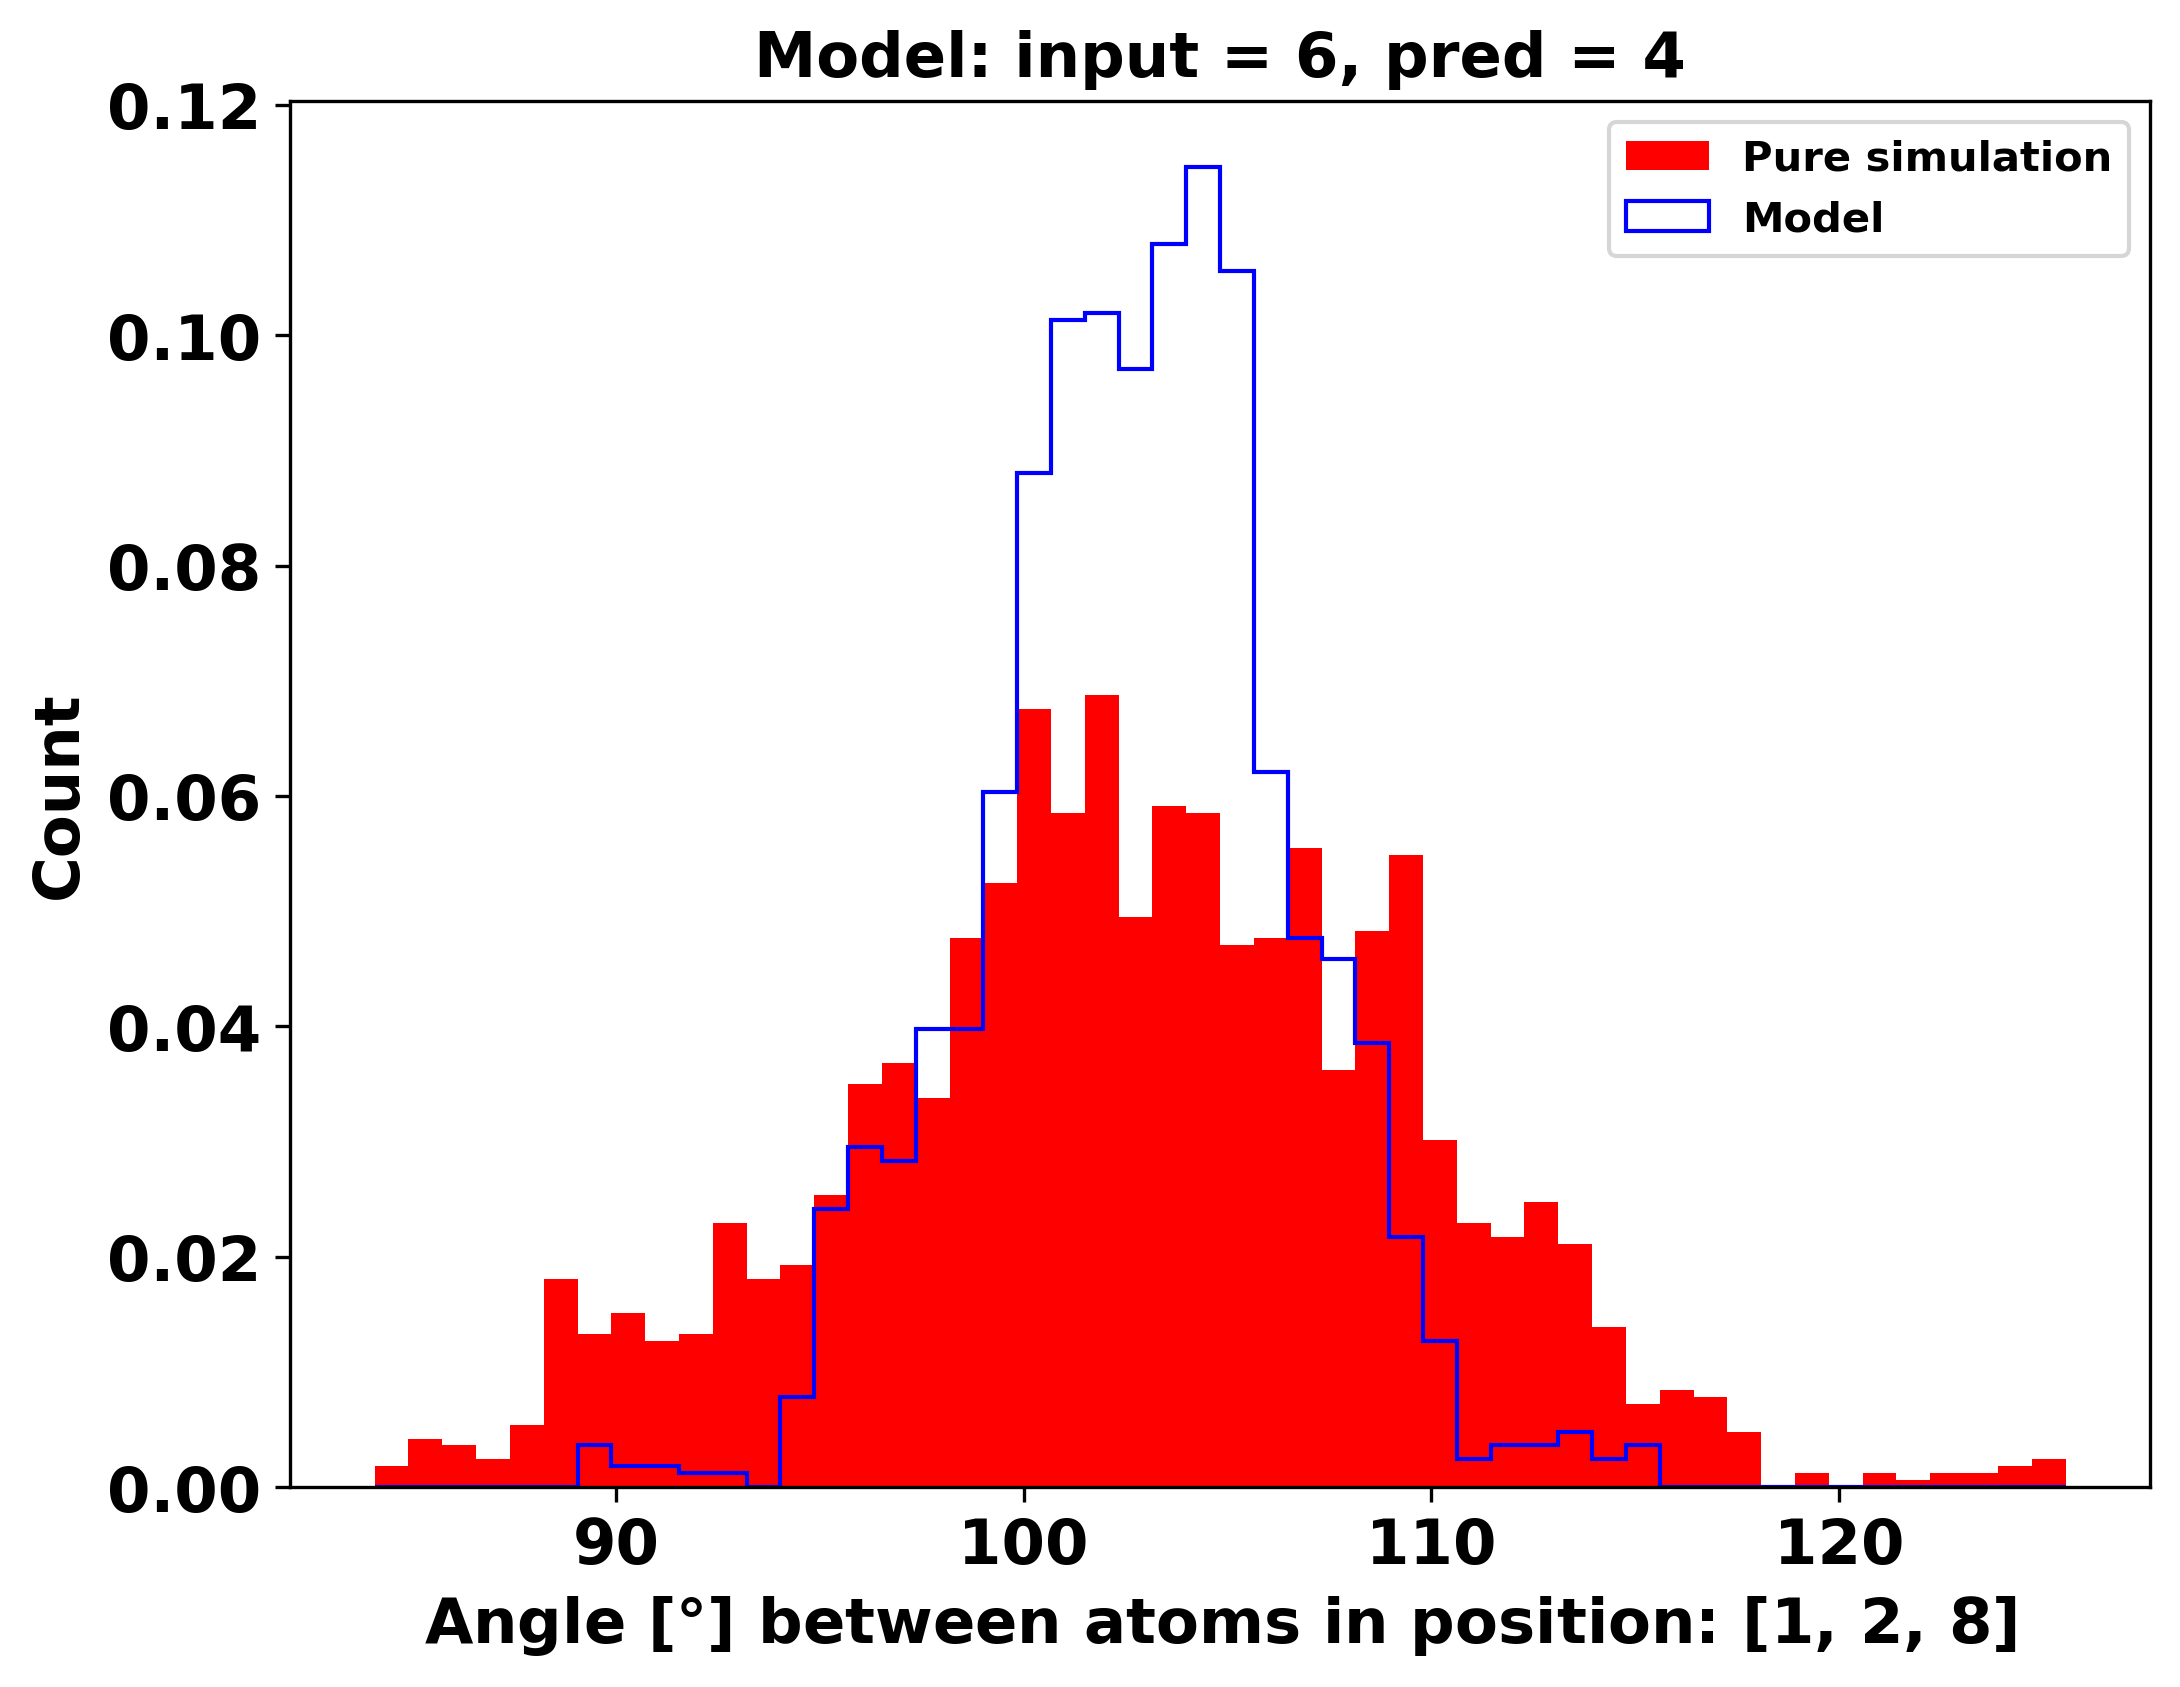

In [31]:
def get_angles(mol, a1, a2, a3):
    angles = []
    for atom in mol:
        angles.append(atom.get_angle(a1, a2, a3))
    return np.array(angles)

N_bins = 50
indices = [1, 2, 8]
range = (min(get_angles(mol_dyn, *indices))-0.5, max(get_angles(mol_dyn, *indices))+0.5)
print(min(get_angles(mol_model, *indices)), max(get_angles(mol_model, *indices)))
print(min(get_angles(mol_dyn, *indices)), max(get_angles(mol_dyn, *indices)))
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(get_angles(mol_dyn, *indices), bins=N_bins, range=range, density=True, label="Pure simulation", histtype="stepfilled", color="r")
ax.hist(get_angles(mol_model, *indices), bins=N_bins, range=range, density=True, label="Model", histtype="step", color="b")
ax.set_xlabel("Angle [$\degree$] between atoms in position: "+str(indices), fontweight="bold")
ax.set_ylabel("Count", fontweight="bold")
ax.set_title("Model: input = 6, pred = 4", fontweight="bold")
plt.minorticks_off()
plt.legend()
plt.show()




In [28]:
print("model mean =",np.mean(get_angles(mol_model, *indices)),"+-",np.var(get_angles(mol_model, *indices)))
print("simuation mean =",np.mean(get_angles(mol_dyn, *indices)),"+-",np.var(get_angles(mol_dyn, *indices)))
print(compare_KS(get_angles(mol_model, *indices), get_angles(mol_dyn, *indices)))

model mean = 106.73454458417973 +- 9.980875749765609
simuation mean = 109.41281577670608 +- 34.57148888524566
KstestResult(statistic=0.3793793793793794, pvalue=1.827768908313095e-128, statistic_location=111.66157171561953, statistic_sign=1)


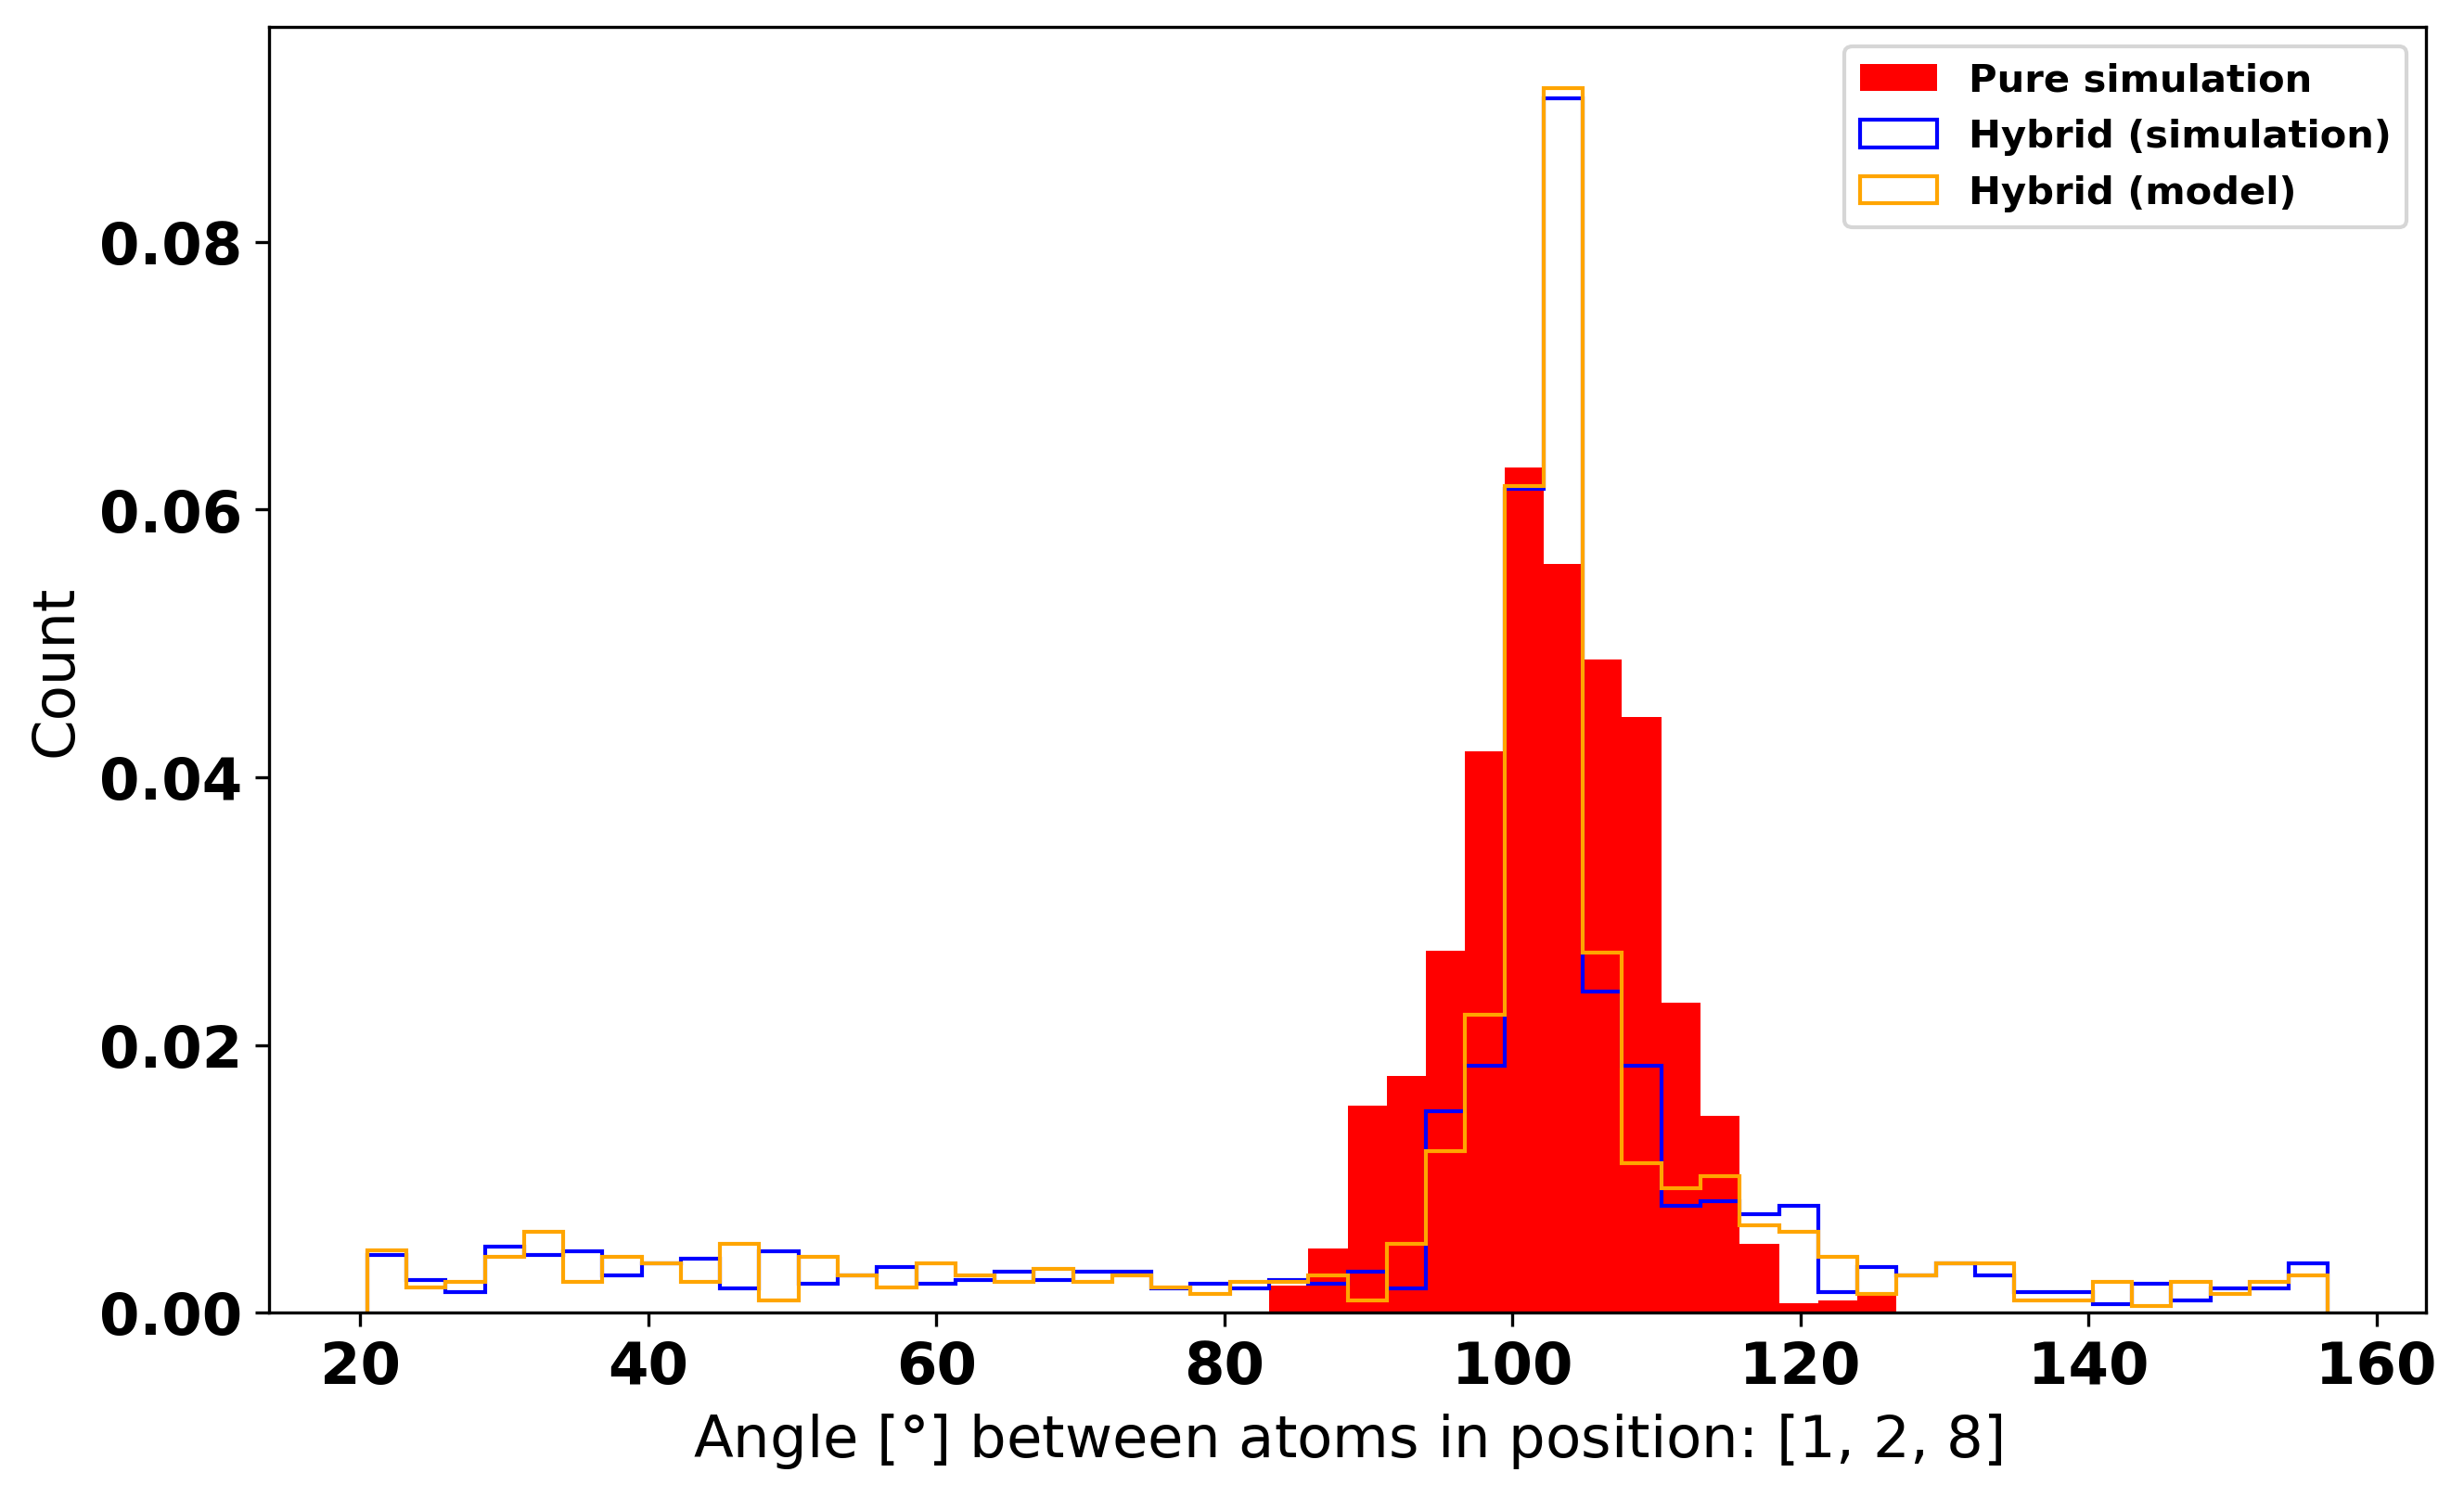

In [ ]:
# Lav et plot hvor der kun indgår steps for simulation og en hvor der kun indgår steps for model
mask1 = np.asarray(df_model.loc[df_model['md']==1, 'Unnamed: 0']).astype('int32')
mask0 = np.asarray(df_model.loc[df_model['md']==0, 'Unnamed: 0']).astype('int32')

fig, ax = plt.subplots(figsize=(10,6))
ax.hist(get_angles(mol_dyn, *indices), bins=N_bins, range=range, density=True, label="Pure simulation", histtype="stepfilled", color="r")
ax.hist(get_angles(mol_model, *indices)[mask1], bins=N_bins, range=range, density=True, label="Hybrid (simulation)", histtype="step", color="b")
ax.hist(get_angles(mol_model, *indices)[mask0], bins=N_bins, range=range, density=True, label="Hybrid (model)", histtype="step", color="orange")
ax.set_xlabel("Angle [$\degree$] between atoms in position: "+str(indices))
ax.set_ylabel("Count")
plt.minorticks_off()
plt.legend()
plt.show()


In [11]:

print(mol_dyn[0].get_atomic_numbers())

KstestResult(statistic=0.15315315315315314, pvalue=7.459471599081934e-21, statistic_location=106.26028202320171, statistic_sign=1)
[6 6 8 1 1 1 1 1 1]


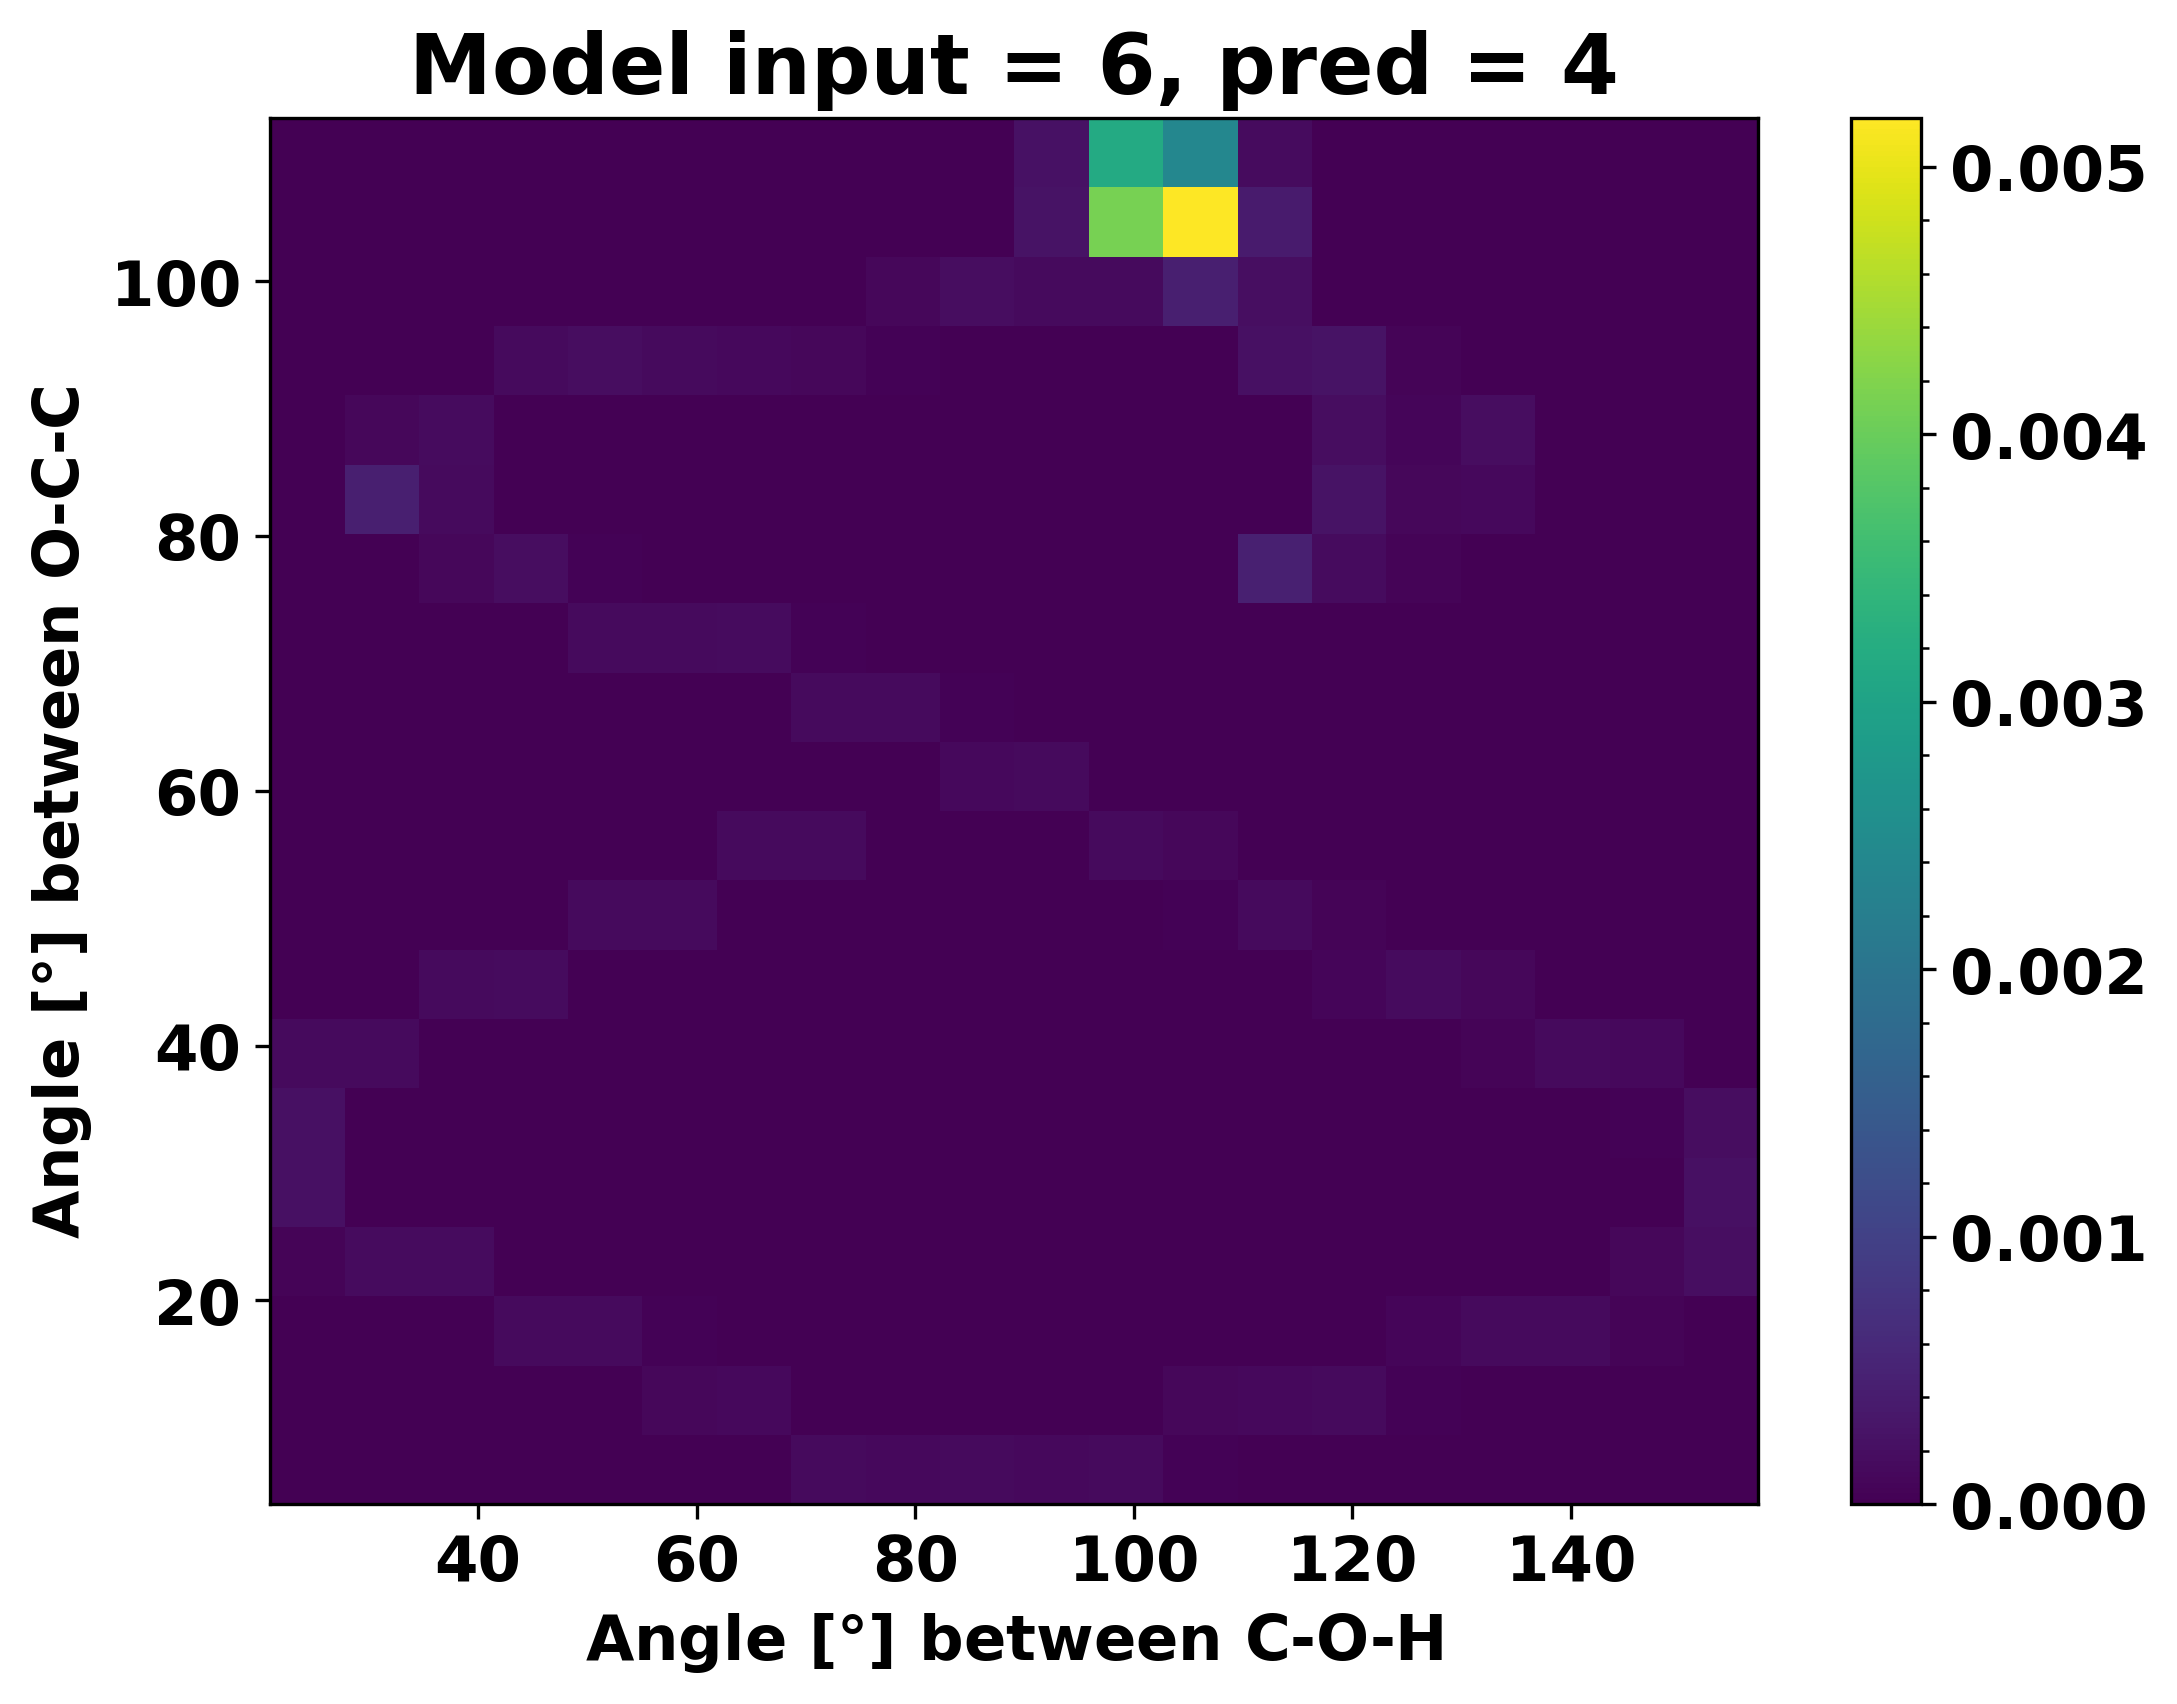

In [55]:
angle1 = get_angles(mol_model, *indices)
angle2 = get_angles(mol_model, 0, 1, 2)

fig, ax = plt.subplots(figsize=(8,6))
im = ax.hist2d(angle1, angle2, bins=20, density=True)
ax.set_xlabel("Angle [$\degree$] between C-O-H", fontweight="bold")
ax.set_ylabel("Angle [$\degree$] between O-C-C", fontweight="bold")
ax.set_title("Model input = 6, pred = 4", fontweight="bold", fontsize=20)
plt.colorbar(im[3])
plt.minorticks_off()
plt.show()

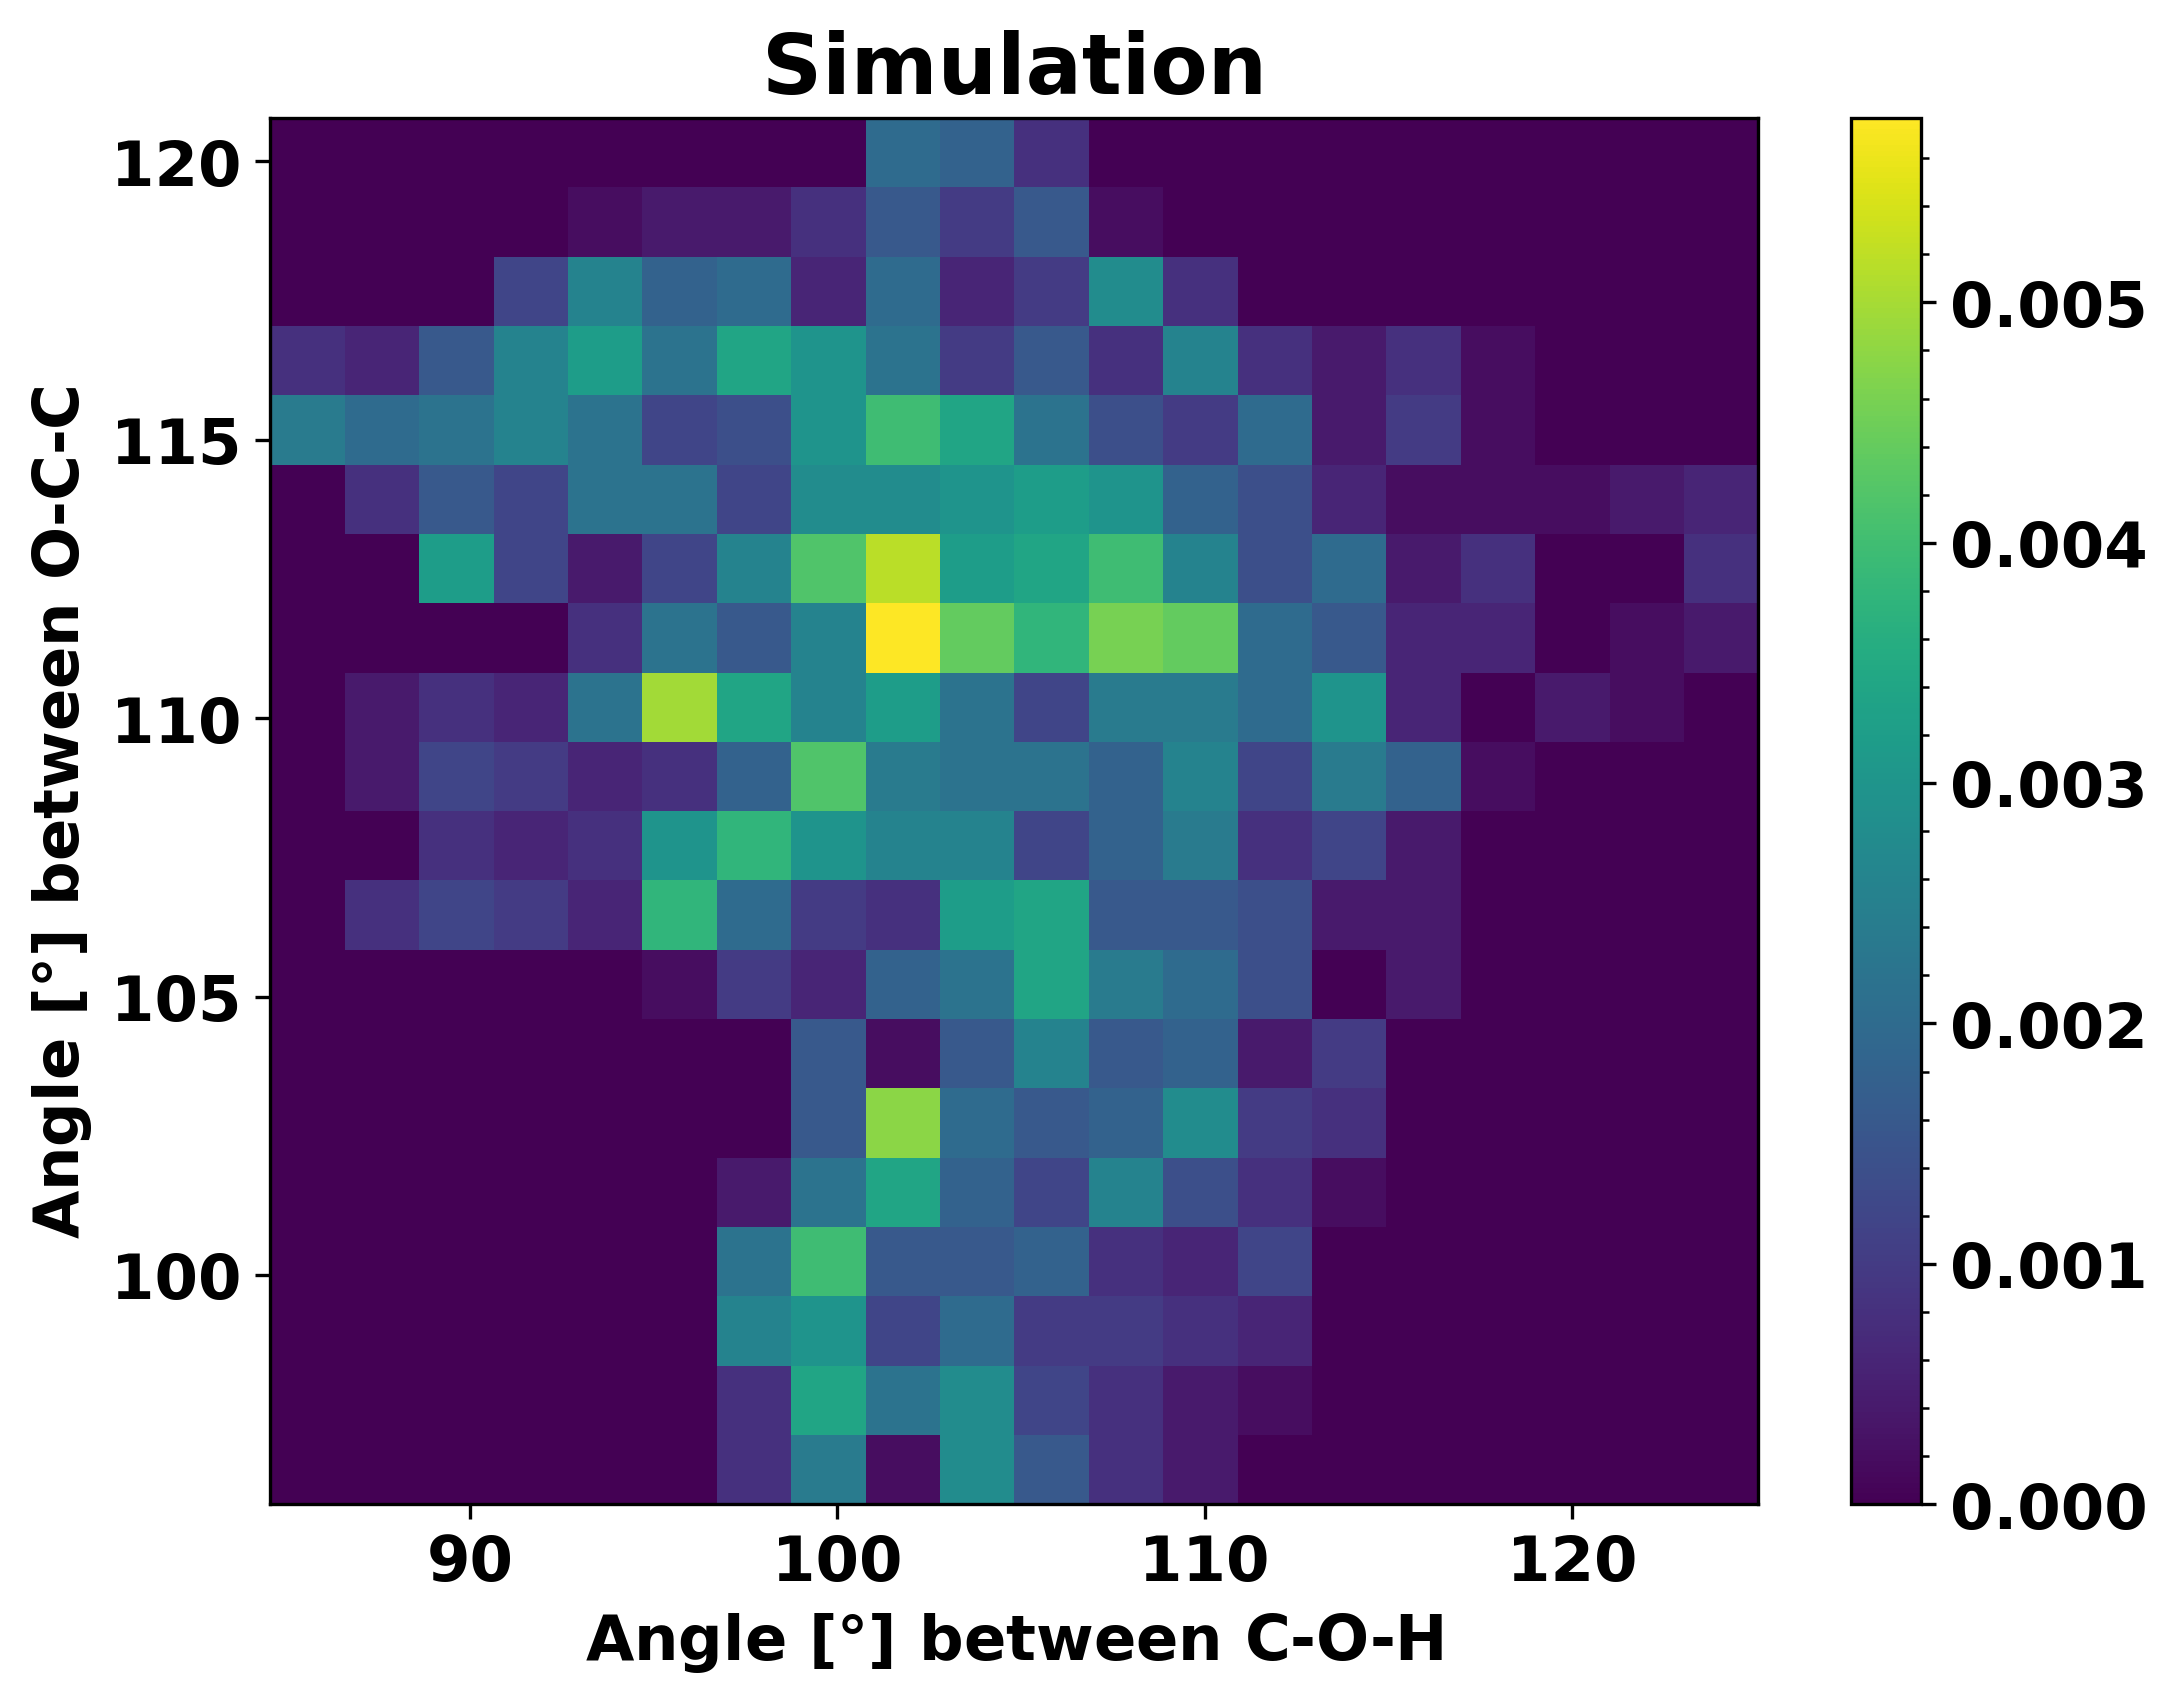

In [56]:
angle1 = get_angles(mol_dyn, *indices)
angle2 = get_angles(mol_dyn, 0, 1, 2)

fig, ax = plt.subplots(figsize=(8,6))
im = ax.hist2d(angle1, angle2, bins=20, density=True)
ax.set_xlabel("Angle [$\degree$] between C-O-H", fontweight="bold")
ax.set_ylabel("Angle [$\degree$] between O-C-C", fontweight="bold")
ax.set_title("Simulation", fontweight="bold", fontsize=20)
plt.colorbar(im[3])
plt.minorticks_off()
plt.show()

# Dihedral angles

99.69911732964428 114.2921078618315
95.88618957009169 120.77651303287671


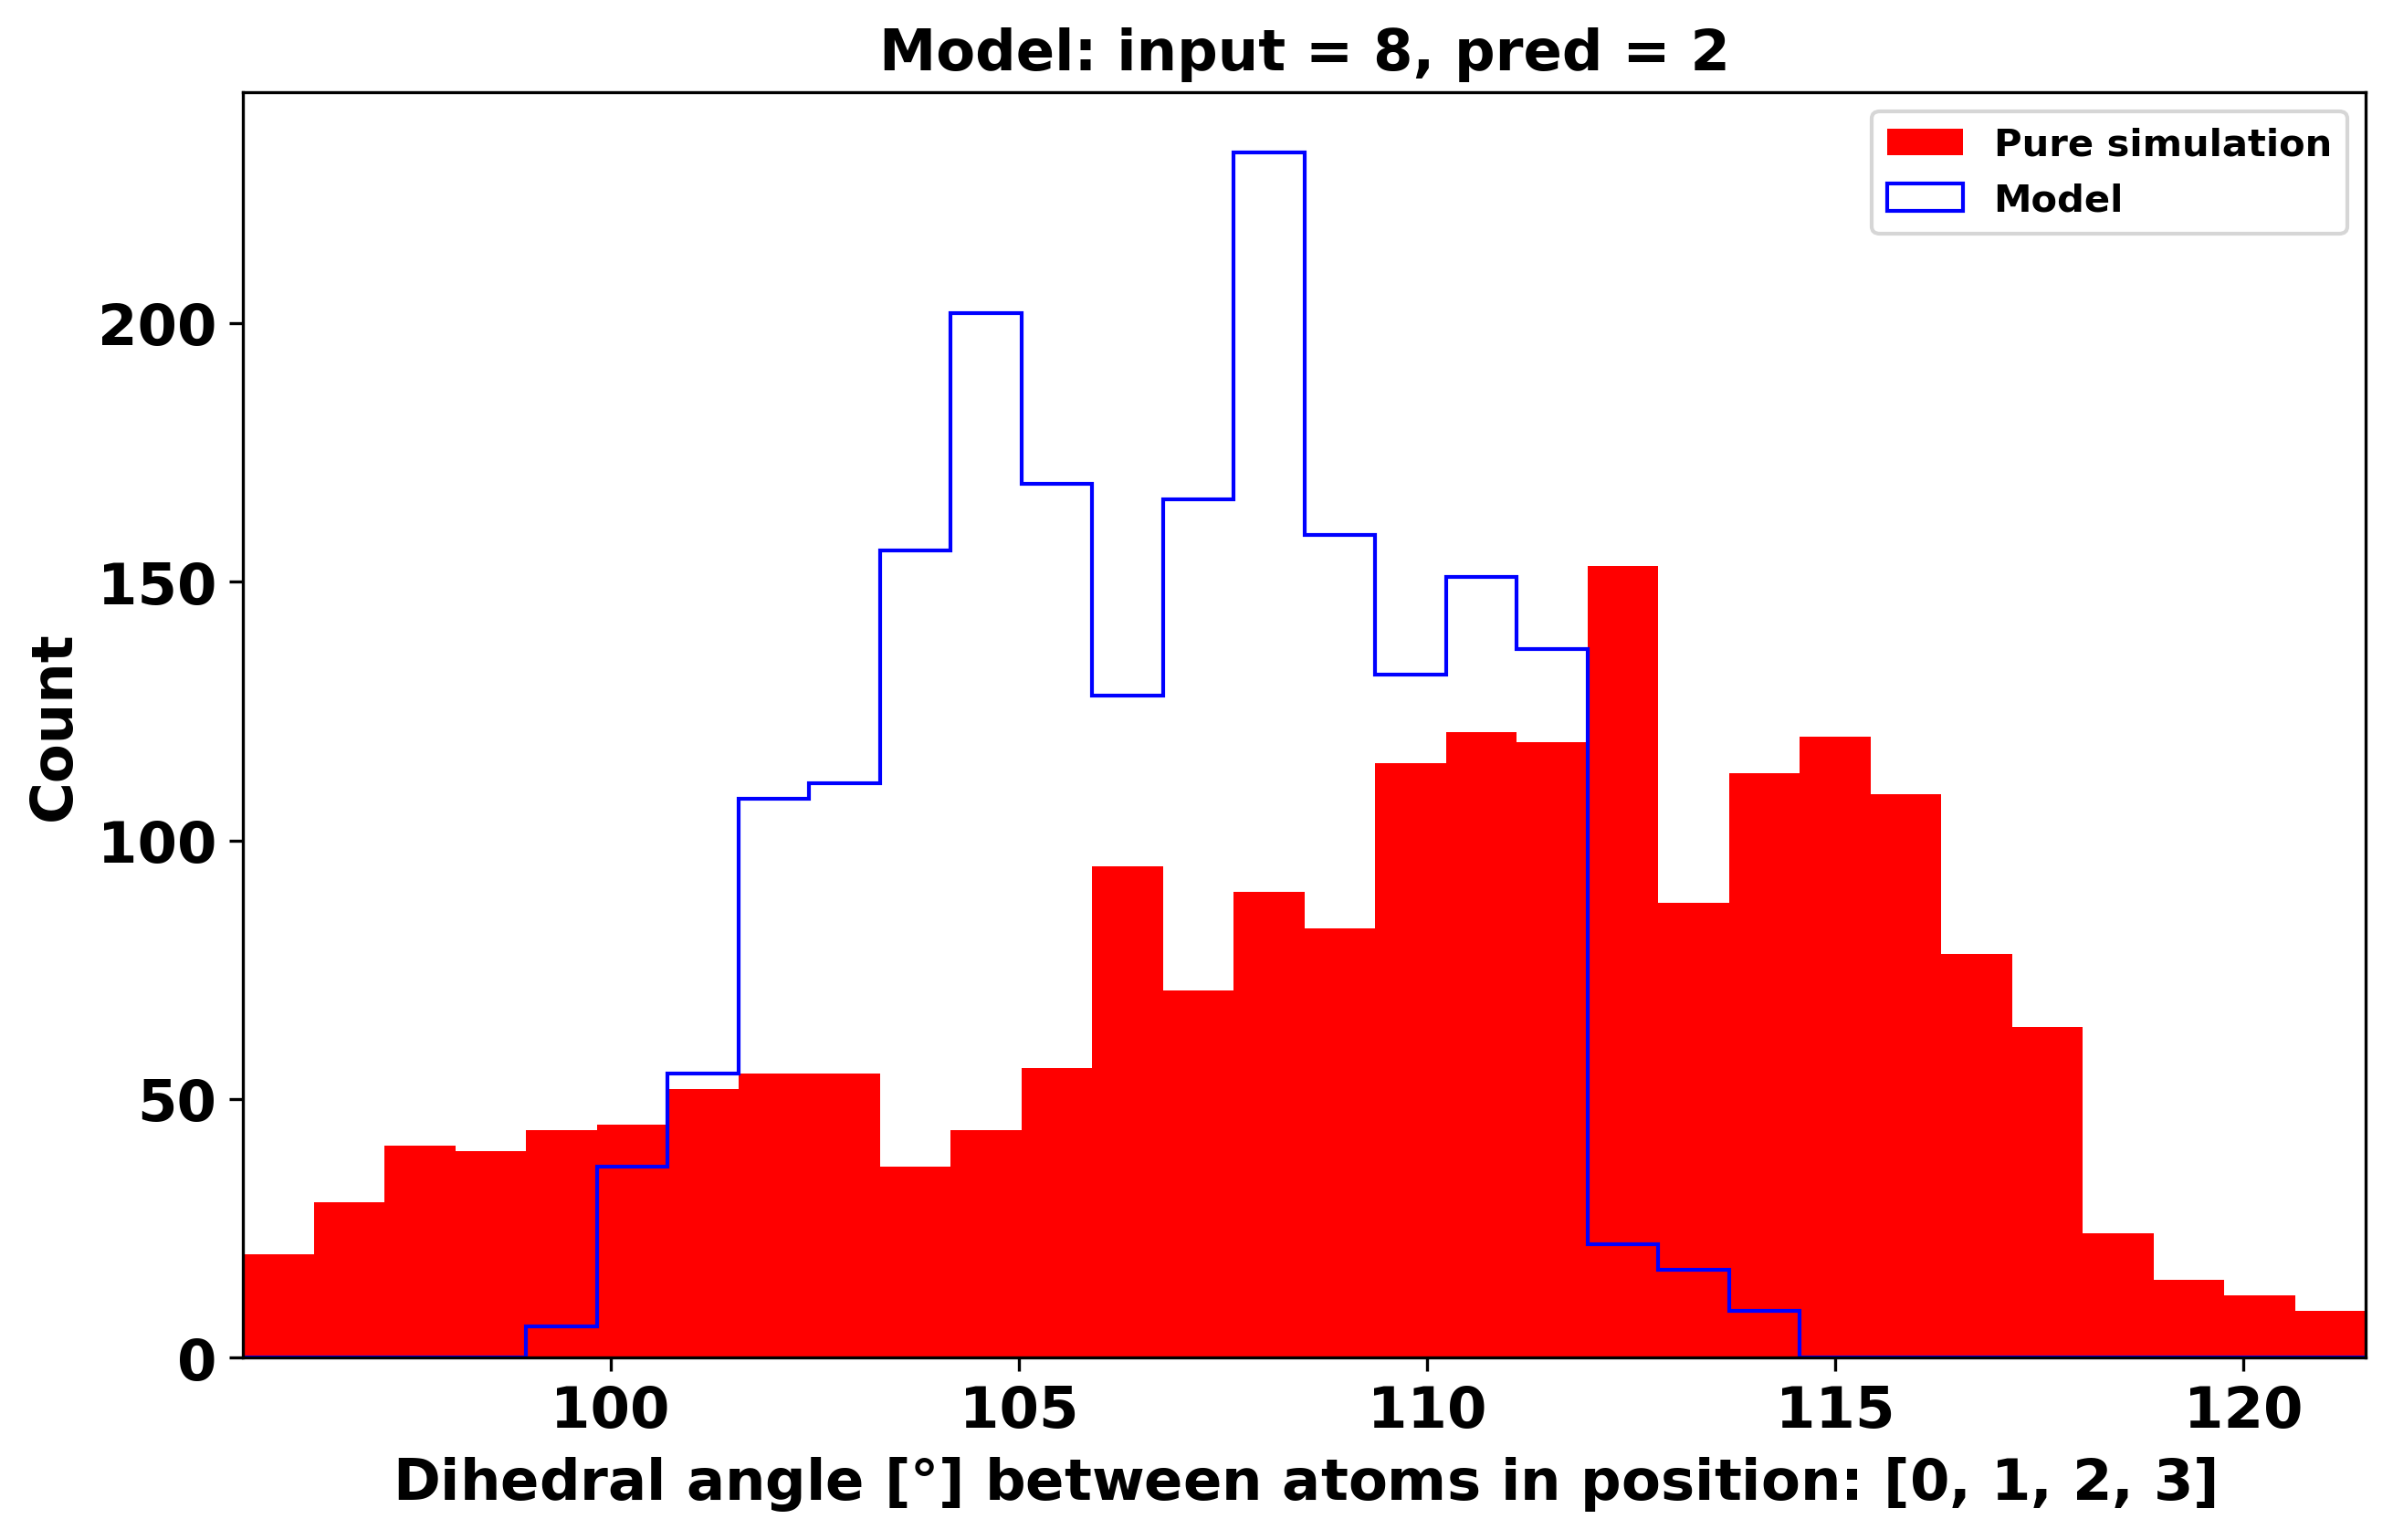

In [19]:
def get_dihedral(mol, a1, a2, a3, a4):
    dihedral = []
    for atom in mol:
        dihedral.append(atom.get_angle(a1, a2, a3, a4))
    return dihedral

N_bins = 30
indices = [0, 1, 2, 3]
print(min(get_dihedral(mol_model, *indices)), max(get_dihedral(mol_model, *indices)))
print(min(get_dihedral(mol_dyn, *indices)), max(get_dihedral(mol_dyn, *indices)))
#range = (3.5, 135.5)
range = (95.5, 121.5)

fig, ax = plt.subplots(figsize=(10,6))
ax.hist(get_dihedral(mol_dyn, *indices), bins=N_bins, range=range, label="Pure simulation", histtype="stepfilled", color="r")
ax.hist(get_dihedral(mol_model, *indices), bins=N_bins, range=range, label="Model", histtype="step", color="b")
ax.set_xlim(range)
ax.set_xlabel("Dihedral angle [$\degree$] between atoms in position: "+str(indices), fontweight="bold")
ax.set_ylabel("Count", fontweight="bold")
ax.set_title("Model: input = 8, pred = 2", fontweight="bold")
plt.minorticks_off()
plt.legend()
plt.show()

# Visualisation

In [57]:
from ase.visualize import view
view(mol_dyn[:], data="charge density")


# Convergence

50
50


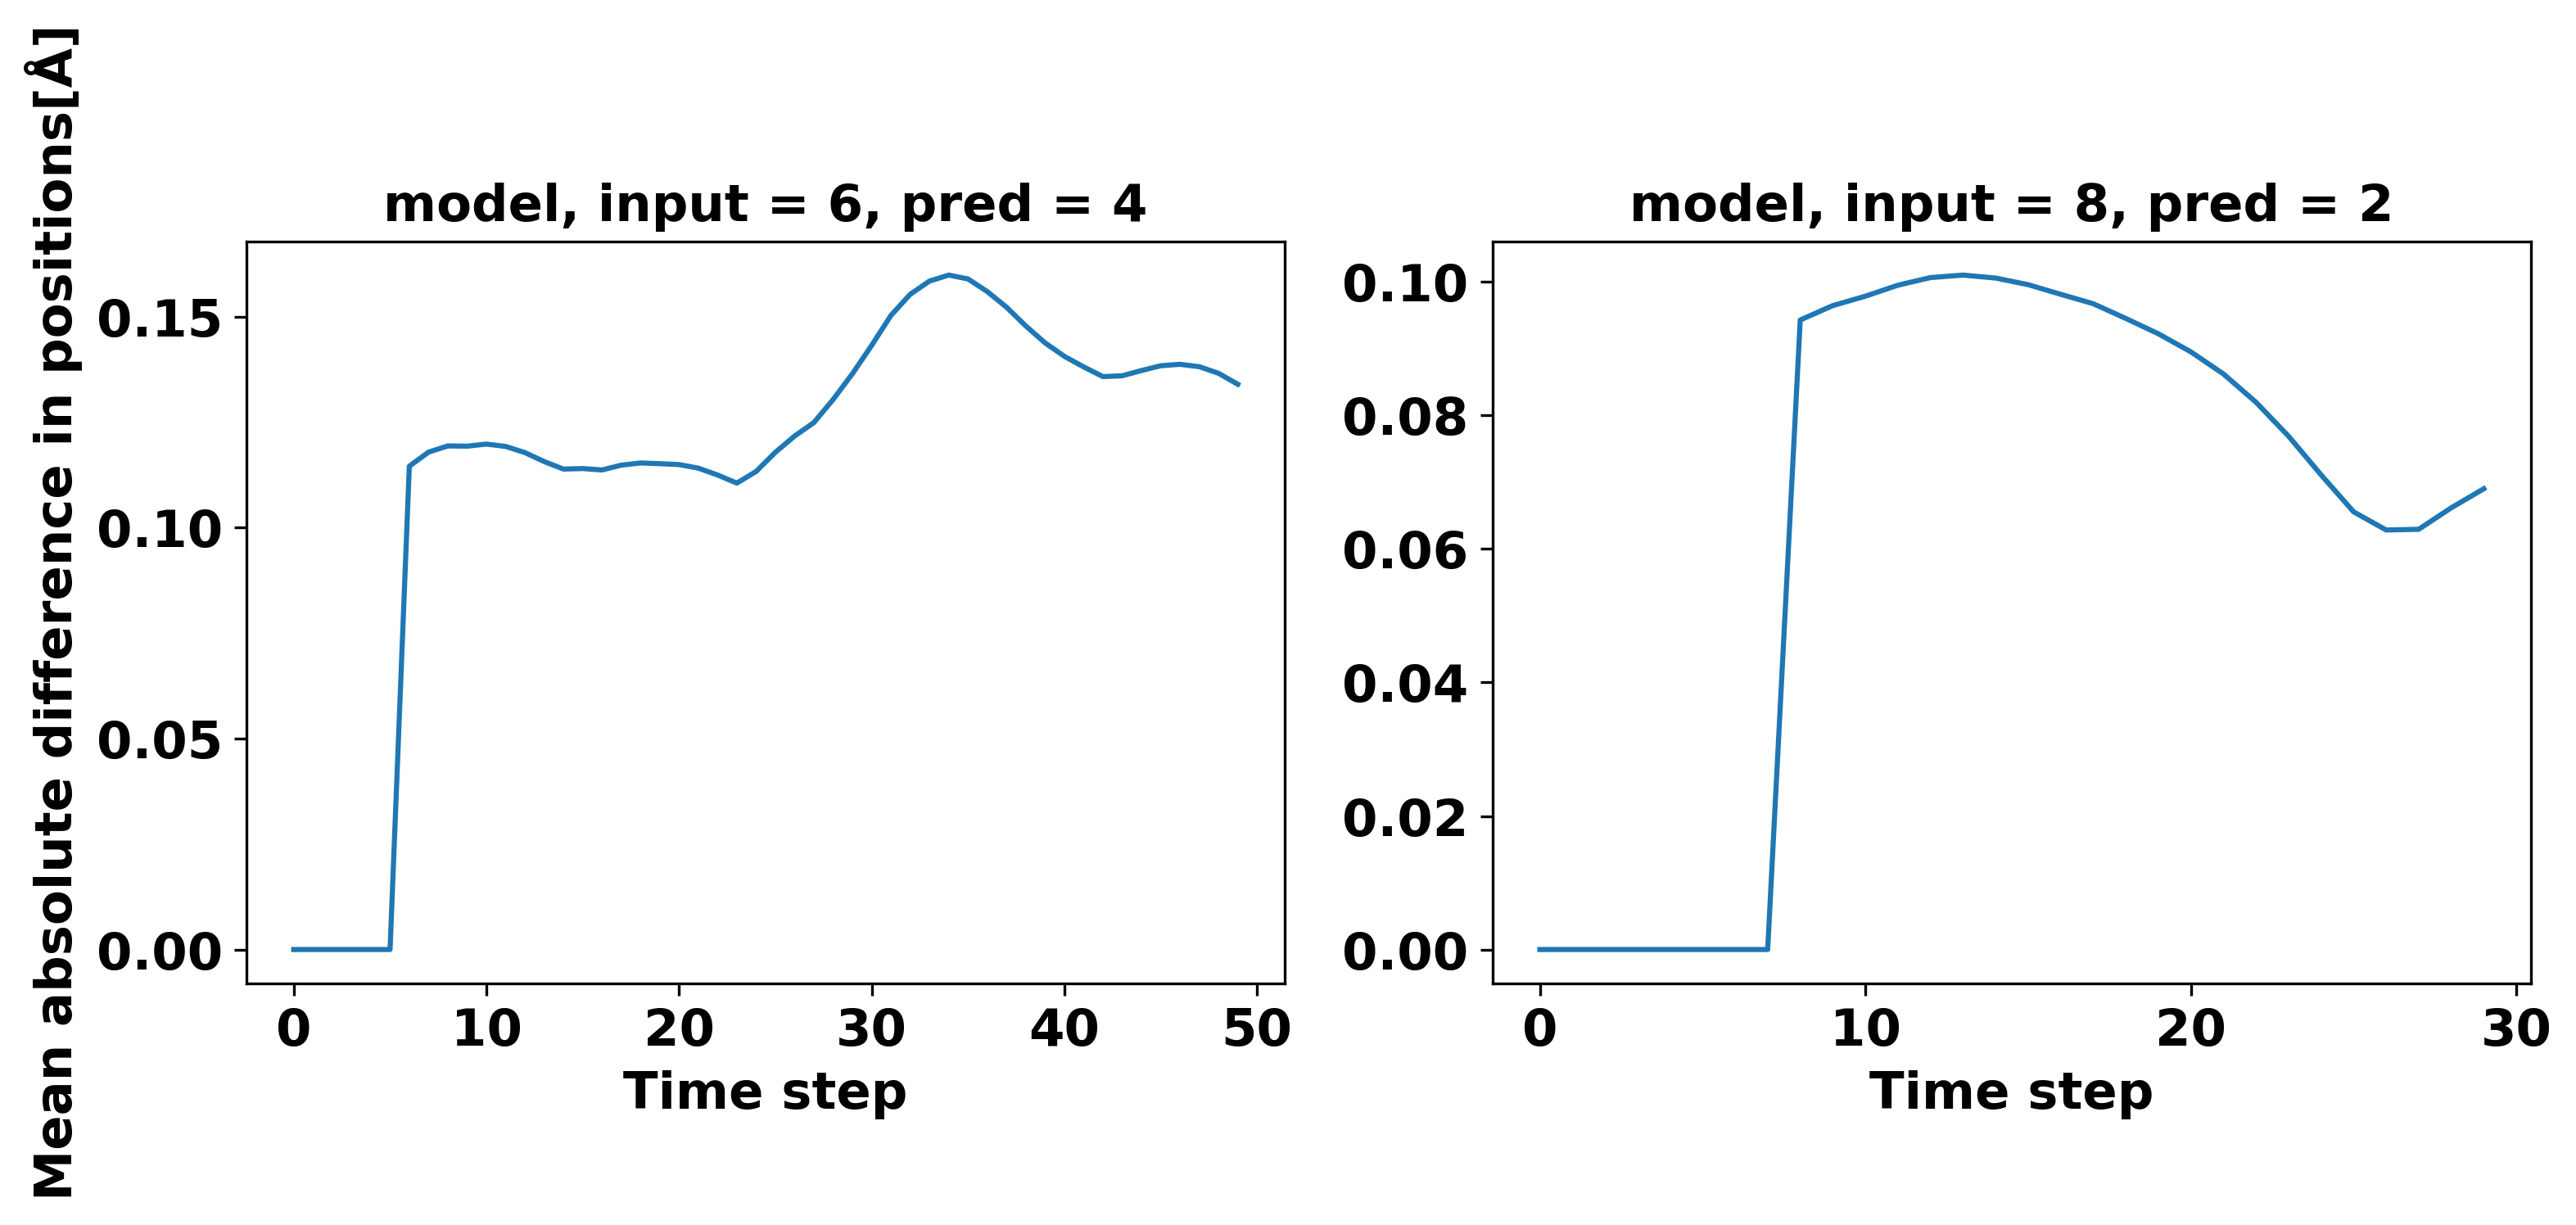

In [4]:
mol_model_6_4 = read("Data/convergence_test.xyz", index=":")
mol_dynamics_6_4 = read("Data/moldyn_test.xyz", index=":")
mol_model_8_2 = read("Data/convergence_test_8_2.xyz", index=":")
mol_dynamics_8_2 = read("Data/moldyn_test_8_2.xyz", index=":")

difference_6_4 = []
for i in range(len(mol_dynamics_6_4)):
    difference_6_4.append(np.mean(np.abs(mol_model_6_4[i].get_positions()-mol_dynamics_6_4[i].get_positions())))
difference_8_2 = []
for i in range(len(mol_dynamics_8_2)):
    difference_8_2.append(np.mean(np.abs(mol_model_8_2[i].get_positions()-mol_dynamics_8_2[i].get_positions())))

print(len(difference_6_4))
print(len(mol_dynamics_6_4))
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].plot(range(len(mol_dynamics_6_4)), difference_6_4)
ax[0].set_title("model, input = 6, pred = 4", fontweight="bold")
ax[1].plot(range(len(mol_dynamics_8_2)), difference_8_2)
ax[1].set_title("model, input = 8, pred = 2", fontweight="bold")
ax[0].set_ylabel("Mean absolute difference in positions[Å]", fontweight="bold")
ax[0].set_xlabel("Time step", fontweight="bold")
ax[1].set_xlabel("Time step", fontweight="bold")
ax[0].minorticks_off()
ax[1].minorticks_off()
plt.show()